In [37]:
from datetime import datetime, date
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import re, os, nltk, math, csv, json, scipy, string

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Google Drive - This will prompt you to click a link to authorize
# (don't execute if running on own machine)
from google.colab import drive, auth, files
from oauth2client.client import GoogleCredentials
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Google Drive - Navigate to directory
# (don't execute if running on own machine)
os.chdir('drive/MyDrive/SocialComQuant22/')
os.listdir('.')

['Data',
 'Resources_geolocation',
 'Resources_nutrition',
 'Resources_sentiment',
 'Obesity.ipynb',
 'MentalHealth.ipynb',
 'Loneliness.ipynb']

# NLP for health -- loneliness and change over time

Sometimes we want to track a development of health-related variables over time, and detect then they change.

1. Classifying loneliness
2. Interrupted time series analysis

# 3.1 Text classification

In [2]:
# Read in tweets that have been classified for whether or not they are self-disclosures of loneliness
tweets_loneliness_training = pd.read_csv("Data/loneliness_training.tsv", sep="\t", lineterminator='\n',
                  low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
                  names=["text", "disclosure"], dtype={'id': object})
tweets_loneliness_training.shape

(1355, 2)

In [3]:
pd.options.display.max_colwidth = 1000
tweets_loneliness_training.head()

,text,disclosure
0,“do you ever get lonely?” “of course not. i remain lonely” 😂,Self-Disclosure
1,@HeresyAndDemise Ahhh. Well. She’ll just plop herself into the Avenger’s lap. There. She has a neet to not be so lonely now..!,Irrelevant
2,I’m mad my dawg moved out of state. Now all I do is face woods by my lonely.,Self-Disclosure
3,"@PolhomeEditor TM lost control a long time ago, she has huge divisions within the Tory Party, now she dictates from a lonely place. Corbyn has got many MPs on his side (Margaret Becket for example) that is why a small number of anti Corbyn MPs have splintered.",Irrelevant
4,@DrAmirKhanGP I had an teen girl in once post suicide attempt. She was unaccompanied; scared and lonely and not eating much at all.I ordered us some McDonald's via deliveroo to share by her bed.Yes it's unhealthy but just then she needed someone to show they cared.That and chicken nuggets.,Irrelevant


In [4]:
tweets_loneliness_training.disclosure.value_counts()

Self-Disclosure    711
Irrelevant         644
Name: disclosure, dtype: int64

In [5]:
# Do initial cleaning of the text

# Function to clean the text
re_url = re.compile(r'https?:\/\/.*[\r\n]*', flags=re.U)
re_rtw = re.compile(r'RT', flags=re.U)
re_htg = re.compile(r'#', flags=re.U) # remove hashtag sign
#re_htg = re.compile(r'#[\w]+ ?', flags=re.U)   # remove hashtags
re_hnd = re.compile(r'@\w+ ?', flags=re.U)
re_wrd = re.compile(r'[^\w]+ ', flags=re.U)
re_num = re.compile(r'[0-9]+', flags=re.U)

def cleantext(txt):
    t = txt
    t = re_url.sub('', t)
    t = re_htg.sub('', t)
    t = re_rtw.sub(' ', t)
    t = re_hnd.sub(' ', t)
    t = re_wrd.sub(' ', t)
    t = re_num.sub(' ', t)
    
    return t.strip().lower()

tweets_loneliness_training["text_clean"] = tweets_loneliness_training.text.apply(lambda x: cleantext(x))

In [6]:
# Calculate term vector features
cv = CountVectorizer(ngram_range=(1,3))  # 1 - 3 grams
featurematrix = cv.fit_transform(tweets_loneliness_training["text_clean"])

In [7]:
# Compute additional features

# Whether or not the tweet is directed to a particular user
tweets_loneliness_training["f_direct"] = tweets_loneliness_training.text.str.startswith("@").astype(int)
featurematrix = scipy.sparse.hstack((featurematrix, np.asmatrix(tweets_loneliness_training["f_direct"]).T))
# How many letters are upper case
tweets_loneliness_training["f_caps"] = tweets_loneliness_training["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x))  
featurematrix = scipy.sparse.hstack((featurematrix, np.asmatrix(tweets_loneliness_training["f_caps"]).T))
# How many letters are punctuation
tweets_loneliness_training["f_punc"] = tweets_loneliness_training["text"].apply(lambda x: math.log(sum([1 for c in x if c in string.punctuation])+1))
featurematrix = scipy.sparse.hstack((featurematrix, np.asmatrix(tweets_loneliness_training["f_punc"]).T))

In [8]:
# Output variable
y = (tweets_loneliness_training.disclosure == 'Self-Disclosure').astype(int)
y.mean()

0.5247232472324723

In [9]:
# Build a model -- here an SVM
model = svm.SVC(class_weight="balanced", kernel='rbf', gamma=0.0001, C=1000)

In [10]:
# Evaluate it
print(cross_val_score(model, featurematrix, y, scoring="accuracy").mean())
print(cross_val_score(model, featurematrix, y, scoring="precision").mean())
print(cross_val_score(model, featurematrix, y, scoring="recall").mean())

0.721771217712177
0.7094486312847825
0.8200827341672412


In [11]:
# Train the model using all of the training sets
model.fit(featurematrix, y)

SVC(C=1000, class_weight='balanced', gamma=0.0001)

In [12]:
# Apply to a raw data file of possible self disclosures
tweets_loneliness_day = pd.read_csv("Data/loneliness_day_sample.tsv", sep="\t", lineterminator='\n',
                  low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
                  names=["text"], dtype={'id': object})
tweets_loneliness_day.shape

(21598, 1)

In [13]:
tweets_loneliness_day.sample(5)["text"]

15955                                                                                                                                                                       Just feeling bored and lonely at him🤦🤦 who's in to chat me up and make me feel horny😍😍😍🤔🤔 https://t.co/sytBCtJq35
16205                                                                                                                                      when you form a habit of talking to someone every night and then one night the person isn’t there anymore and everything’s just so sad and lonely💔
16904                                                                                                                     @KatlegoMkalipi They talking about some status where Goody was close to tears and the whole squad was laughing at him 😓 me he told me it’s because he was lonely 😭😭
7903                                                                                                                                          

In [14]:
# Create features for the text and apply the model
tweets_loneliness_day["text_clean"] = tweets_loneliness_day.text.apply(lambda x: cleantext(x)) 
# Compute additional features
tweets_loneliness_day["f_direct"] = tweets_loneliness_day.text.str.startswith("@").astype(int)
tweets_loneliness_day["f_caps"] = tweets_loneliness_day["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x))  
tweets_loneliness_day["f_punc"] = tweets_loneliness_day["text"].apply(lambda x: math.log(sum([1 for c in x if c in string.punctuation])+1))
# Compute text vector as in training data
afeaturematrix = cv.transform(tweets_loneliness_day["text_clean"])
afeaturematrix = scipy.sparse.hstack((afeaturematrix, np.asmatrix(tweets_loneliness_day["f_direct"]).T))
afeaturematrix = scipy.sparse.hstack((afeaturematrix, np.asmatrix(tweets_loneliness_day["f_caps"]).T))
afeaturematrix = scipy.sparse.hstack((afeaturematrix, np.asmatrix(tweets_loneliness_day["f_punc"]).T))
# Predict the relevance for the dataset
y_pred = model.predict(afeaturematrix)
# Select the records classified as positive
selected = tweets_loneliness_day.loc[y_pred.astype(bool)]

In [15]:
selected.shape

(10304, 5)

In [16]:
selected.sample(5)["text"]

814                                                                                              @maxatuna hey lonely im doing coke https://t.co/oQpwltvSPg
17389                                                                              RT @xixo_99: empty, lonely, and broken   just as my body, heart and soul
9062     when you form a habit of talking to someone every night and then one night the person isn’t there anymore and everything’s just so sad and lonely💔
17373                                                                                                                        My apartment feels lonely now.
11304                                                                                                           RT @meredithmgm: don’t settle cuz ur lonely
Name: text, dtype: object

## 3.2 Interrupted Time Series Analysis

When we have a time series of some variable, an event happened, how do we know whether it changed the variable after the event?

For more, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5407170/

In [17]:
# Read in a time series of unique users posting loneliness self-disclosures
# over the span of 2 years around COVID-19 lockdowns.
# covid variable is 1 after May 14, 2020 when lockdowns in USA began
timeseries = pd.read_csv("Data/loneliness_time_series.tsv", sep="\t")
timeseries

,cnt,mydate,covid
0,4011,2019-03-15,0
1,4342,2019-03-16,0
2,4563,2019-03-17,0
3,4340,2019-03-18,0
4,4422,2019-03-19,0
...,...,...,...
726,4856,2021-03-10,1
727,4907,2021-03-11,1
728,4685,2021-03-12,1
729,4875,2021-03-13,1


<AxesSubplot:xlabel='mydate'>

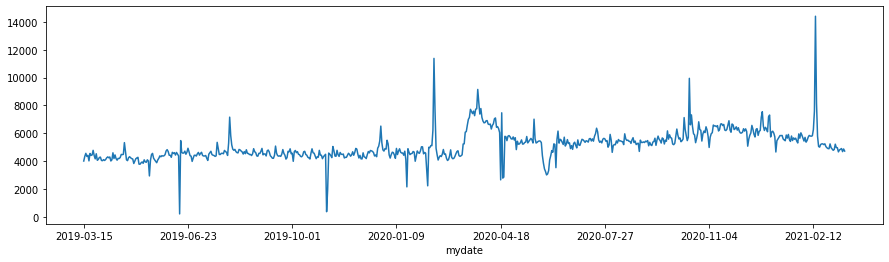

In [18]:
# Plot the count
timeseries.set_index("mydate").cnt.plot(figsize=(15,4))

In [19]:
# Find the dates that probably had outages, read in suspicious days
# (that had outages for 2+ hours, computed on original data)
missing_days = pd.read_csv("Data/loneliness_missing_days.txt")
missing_days = missing_days[missing_days.hours_missing>1]
missing_days

,date,hours_missing
0,2019-11-03,21
1,2019-06-15,21
2,2019-11-04,14
3,2020-04-18,14
4,2020-04-20,13
5,2019-02-20,12
6,2020-02-08,12
7,2020-01-19,12
8,2020-04-21,11
9,2019-03-04,9


In [20]:
# Format the dates
missing_days["date"] = pd.to_datetime(missing_days["date"], format='%Y-%m-%d')
timeseries["mydate"] = pd.to_datetime(timeseries["mydate"], format='%Y-%m-%d')
# Create a smoothed time series where there is missing data
timeseries["cnt_smooth"] = timeseries.cnt
timeseries.loc[timeseries.mydate.isin(missing_days.date), "cnt_smooth"] = None
timeseries["cnt_smooth"] = timeseries.cnt_smooth.astype(float).interpolate()

<AxesSubplot:xlabel='mydate'>

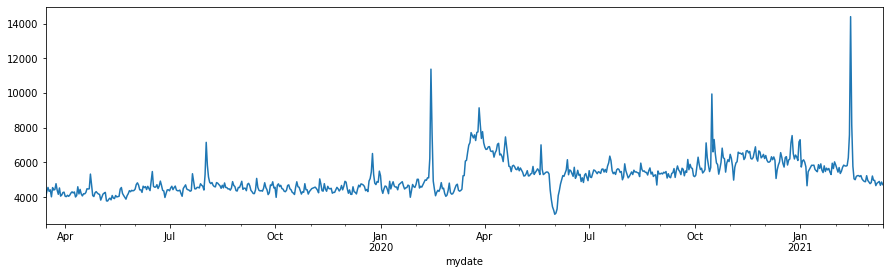

In [21]:
# Plot smoothed volume
timeseries.set_index("mydate").cnt_smooth.plot(figsize=(15,4))

In [22]:
# Prepare time count-off for ITS analysis
start_time = timeseries['mydate'].min()
timeseries['time'] = (timeseries.mydate - start_time).transform(lambda x: x.days)

In [23]:
# Run the ITS regression
mod = smf.ols(formula = "cnt_smooth ~ time + covid + time*covid", data=timeseries) 
# cnt_smooth - number of unique users posting self-disclosures of longliness
# time - time count in days
# covid - indicator variable, 1 after March 15, 2020  
# time * covid - trend after onset of COVID-19
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.426     
Dependent Variable: cnt_smooth       AIC:                11737.1148
Date:               2022-07-19 09:52 BIC:                11755.4925
No. Observations:   731              Log-Likelihood:     -5864.6   
Df Model:           3                F-statistic:        181.3     
Df Residuals:       727              Prob (F-statistic): 9.26e-88  
R-squared:          0.428            Scale:              5.4739e+05
-------------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept     4282.1302  77.1875 55.4770 0.0000 4130.5931 4433.6673
time             1.4227   0.3660  3.8868 0.0001    0.7041    2.1413
covid         1770.2344 219.1427  8.0780 0.0000 1340.0064 2200.4624
time:covid      -1.8860   0.5187 -3.6360 0.0003   -2.9044   -0.8677
-------------------------------------------------------------------
Omnibus:              662.843      Durbin-Watson:         0.643    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      43426.832
Skew:                 3.747        Prob(JB):              0.000    
Kurtosis:             40.008       Condition No.:         4587     
===================================================================
* The condition number is large (5e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [36]:
print ("On average, before COVID on average %d users posted per day." %(res.params["Intercept"]))
print ("After March 15, 2020, an average of %d more users posted per day." %(res.params["covid"]))

On average, before COVID on average 4282 users posted per day.
After March 15, 2020, an average of 1770 more users posted per day.


In [24]:
timeseries = timeseries.set_index("mydate")

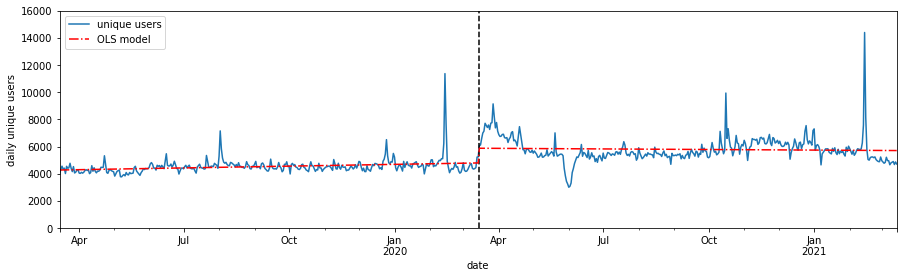

In [25]:
# Plot the data and the model
ax = timeseries.cnt_smooth.plot(figsize=(15,4), label="unique users")
ax.set(xlabel="date", ylabel="daily unique users")
ax.axvline(pd.to_datetime('2020-03-15'), color='k', linestyle='--')
ax.plot(timeseries.index, res.fittedvalues, 'r-.', label="OLS model")
ax.set_facecolor('white')
ax.set_ylim((0,16000))
ax.legend(loc='best')